# All Spectrogram Code Setup

In [1]:
%matplotlib inline
import random
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal, stats
from sklearn.decomposition import NMF
import pandas as pd

def get_all_pat_chn_trials(base_data_dir, patient_num, session_idx, tot_num_channels, 
                           core_cat, trials_type, ord):
    # TODO: Fix the default norm value to be None, and allow other norms to flow through
    """Get all trials for each channel for a given category"""    
    
    patient_ref = f"P{patient_num:02}"
    #print("patient_ref", patient_ref, sep =": ")
    patient_data_dir = os.path.join(base_data_dir, f"{patient_ref}_specgram", 
                                    f"{trials_type}", 
                                    f"session_{session_idx:02}",
                                    f"{core_cat}")
    #print("patient_data_dir", patient_data_dir, sep =": ")
    patient_csv_refs = [os.path.join(patient_data_dir, f"{patient_ref}-ses-{session_idx:02}-chn-{channel_idx + 1:02}-{core_cat}.csv") 
                        for channel_idx in tot_num_channels]
    #print("patient_csv_refs", patient_csv_refs[0], sep =": ")
    all_patient_trials = [np.loadtxt(fname = patient_csv_ref, skiprows = 1, delimiter = ",") for 
                          patient_csv_ref in patient_csv_refs]
    
    # Normalize the trial based on the specified norm type
    if ord is not None:
        print(f"we are using the {ord}-norm to normalize trials")
        all_patient_trials = [trials / np.linalg.norm(trials, ord=ord, axis=1, keepdims=True) for trials in all_patient_trials]

    return all_patient_trials

def samp_idx_without_replace(np_arr, samp_prop, sample_rows):
    """Returns a list of unique row indices from the total number of trials"""
    if sample_rows:
        # sample the number of rows
        sample_type = 0
    else:
        # sample the number of columns
        sample_type = 1
    tot_num_idxs = np_arr.shape[sample_type]
    samp_num_rows = int(np.floor(tot_num_idxs * samp_prop))
    return sorted(random.sample(range(tot_num_idxs), samp_num_rows))

def erp_gen_spectrogram(x, fs, window, nperseg, noverlap, log_Sxx):
    """Generate the spectrogram and return the modulus (or log modulus)"""
    f, t, Sxx = signal.spectrogram(x = x, fs = fs, window = window, nperseg = nperseg, noverlap = noverlap)
    if log_Sxx:
        Sxx = np.log(Sxx)
    return f, t, Sxx

def erp_gen_welch(x, fs, window, nperseg, noverlap):
    """Estimate power spectral density using Welch’s method."""
    f, psd = signal.welch(x = x, fs = fs, window = window, nperseg = nperseg, noverlap = noverlap)
    return f, psd

def specgram_trials(arr_all_trials, fs, window, nperseg, 
                    trials_samp_idx, filter_row_idx, log_Sxx):
    """Produce a combined list of spectrograms concatenated by frequency (horizontally)"""
    if trials_samp_idx is None:
        # Produce spectrograms for all of the trials
        all_trial_idx = range(arr_all_trials.shape[0]) #TODO: Review this - may need to loop channel by channel if the number of channels changes!
        trial_specgrams = [erp_gen_spectrogram(x=arr_all_trials[idx], fs=fs, window=window, nperseg=nperseg, 
                                               noverlap=noverlap, log_Sxx=log_Sxx)[2] for idx in all_trial_idx]
    else:
        # Produce spectrograms for only the specified trials (by trial indices)
        trial_specgrams = [erp_gen_spectrogram(x = arr_all_trials[idx], fs = fs, window = window, nperseg = nperseg, 
                                               noverlap=noverlap, log_Sxx=log_Sxx)[2] for idx in trials_samp_idx]
    
    # Concatenate the combined spectrograms across time i.e. horizontally
    comb_specgram = np.hstack(trial_specgrams)
    
    # Filter the rows of the combined spectrogram    
    if filter_row_idx is None:
        # Don't filter any rows in the combined spectrogram
        comb_specgram = comb_specgram
    else:
        comb_specgram = comb_specgram[filter_row_idx]
    return comb_specgram

def specgram_wrapper(arr_all_trials, tot_num_channels, fs, window, nperseg, 
                     trials_samp_idx, filter_row_idx, log_Sxx):
    """Wrapper to produce spectrograms across all trials (or samples thereof) and the specified
       channels for the particular patient"""
    all_channels_specgrams = [specgram_trials(arr_all_trials=arr_all_trials[channel_idx],
                                              fs = fs, window = window, nperseg = nperseg,
                                              trials_samp_idx=trials_samp_idx, filter_row_idx=filter_row_idx,
                                              log_Sxx=log_Sxx) 
                              for channel_idx in range(len(tot_num_channels))]
    comb_all_channels_specgrams = np.hstack(all_channels_specgrams)
    return comb_all_channels_specgrams

def time_sample_specgram(comb_specgram, time_samp_idx):
    """samples a combined spectrogram of signals (horizontally stacked) and samples by time i.e. shortens by column"""
    return comb_specgram[:, time_samp_idx]    

def nmf_specgrams(comb_specgram, n_components=5, init='random', random_state=0, beta_loss='itakura-saito', solver = 'mu', max_iter=200):
    model = NMF(n_components=n_components, init=init, random_state=random_state, beta_loss=beta_loss, solver=solver, max_iter=max_iter)
    W = model.fit_transform(X=comb_specgram)
    H = model.components_
    return W, H

def nmf_wrapper(comb_all_channels_specgrams, n_components=5, init='random', random_state=0, 
                beta_loss='itakura-saito', solver = 'mu', max_iter=200):
    W, H = nmf_specgrams(comb_all_channels_specgrams, n_components=n_components, init=init, random_state=random_state, 
                         beta_loss=beta_loss, solver=solver, max_iter=max_iter)
    print("V", comb_all_channels_specgrams.shape, sep = ": ")
    print("W", W.shape, sep = ": ")
    print("H", H.shape, sep = ": ")
    return comb_all_channels_specgrams, W, H

### Plot the "basis" vectors i.e. columns of W

def plotW(W, log=True, x_ticks_l=None):
    if log:
        W_plt = np.log(W)
    else:
        W_plt = W
    n_components = W.shape[1]    
    for n in range(W.shape[1]):
        plt.style.use('seaborn')
        plt.figure(figsize=(20, 16), dpi= 80, facecolor='w', edgecolor='k')
        plt.subplot(np.ceil(n_components/2.0), 2, n+1)
        plt.plot(W_plt[:,n])
        plt.title(f'Plot of W Component {n + 1}', fontsize=16)
        #plt.ylim(-2, W_plt.max())
        if x_ticks_l is None:
            plt.xlim(0, W_plt.shape[0])
        else:
            plt.xticks(range(0, W_plt.shape[0]), np.around(x_ticks_l), rotation='vertical')
        plt.ylabel(f'Component {n + 1}')

### Plot the rows of H i.e. the temporal activations

def plotH(H, log=False, y_ticks_l=None):
    print(H.shape[1])
    if log:
        H_plt = np.log(H)
    else:
        H_plt = H
    n_components = H.shape[0]    
    for n in range(H_plt.shape[0]):
        plt.style.use('seaborn')
        plt.figure(figsize=(16, 14), dpi= 80, facecolor='w', edgecolor='k')
        plt.subplot(np.ceil(n_components/2.0), 2, n+1)
        plt.title(f'Plot of H Component {n + 1}', fontsize=16)
        plt.plot(H_plt[n])
        #if y_ticks_l is None:
        #    plt.ylim(0, H_plt.shape[1])
        #else:
        #    plt.yticks(range(0, H_plt.shape[1]), np.around(y_ticks_l, decimals=-1), rotation='vertical')
        #plt.ylim(0, H.max())
        plt.xlim(0, H_plt.shape[1])
        plt.ylabel(f'Component {n + 1}')
        
def entire_specgram_nmf_wrapper(base_data_dir, core_cat, trials_type,
                                patient_num, session_idx, tot_num_channels, samp_trial_pop, 
                                noverlap,
                                ord,
                                time_samp_prop,
                                filter_row_idx,                                
                                log_Sxx,
                                fs, window, nperseg,
                                n_components, 
                                init, 
                                random_state, 
                                beta_loss, 
                                solver,
                                max_iter):
    
    # Get all the channels and trials (DONE)
    all_patient_trials = get_all_pat_chn_trials(base_data_dir=base_data_dir, patient_num=patient_num, 
                                                session_idx=session_idx, tot_num_channels=tot_num_channels, 
                                                core_cat=core_cat, trials_type=trials_type, ord=ord)

    trials_samp_idx = samp_idx_without_replace(np_arr=all_patient_trials[0], samp_prop=samp_trial_pop, 
                                               sample_rows=True)
    print(len(trials_samp_idx))

    # Fit the spectrograms and hstack the spectrograms
    comb_all_channels_specgrams = specgram_wrapper(arr_all_trials=all_patient_trials, 
                                                   trials_samp_idx=trials_samp_idx, 
                                                   tot_num_channels=tot_num_channels,
                                                   fs=fs, window=window, nperseg=nperseg,
                                                   filter_row_idx=filter_row_idx, 
                                                   log_Sxx=log_Sxx)

    # randomly sample across time
    time_samp_idx = samp_idx_without_replace(np_arr=comb_all_channels_specgrams, 
                                             samp_prop=time_samp_prop, 
                                             sample_rows=False)
    
    print("comb_all_channels_specgrams:", comb_all_channels_specgrams.shape, sep = " ")
    print("time_samp_idx length:", len(time_samp_idx), sep = " ")

    comb_specgram_time_sample = time_sample_specgram(comb_specgram=comb_all_channels_specgrams, 
                                                     time_samp_idx=time_samp_idx)
    
    print("comb_specgram_time_sample:", comb_specgram_time_sample.shape, sep=" ")
    
    print("STARTING NMF...")
    
    # perform NMF
    V, W, H = nmf_wrapper(comb_all_channels_specgrams=comb_specgram_time_sample, 
                          n_components=n_components,
                          init=init, 
                          random_state=random_state, 
                          beta_loss=beta_loss, 
                          solver=solver,
                          max_iter=max_iter)
    
    print("NMF COMPLETE!")
    
    return V, W, H        

In [2]:
def entire_specgram_nmf_wrapper_cust(all_patient_trials,
                                     samp_trial_pop, 
                                     noverlap,
                                    time_samp_prop,
                                    filter_row_idx,                                
                                    log_Sxx,
                                    fs, window, nperseg,
                                    n_components, 
                                    init, 
                                    random_state, 
                                    beta_loss, 
                                    solver,
                                    max_iter):

    trials_samp_idx = samp_idx_without_replace(np_arr=all_patient_trials[0], samp_prop=samp_trial_pop, 
                                               sample_rows=True)
    print(len(trials_samp_idx))

    # Fit the spectrograms and hstack the spectrograms
    comb_all_channels_specgrams = specgram_wrapper(arr_all_trials=all_patient_trials, 
                                                   trials_samp_idx=trials_samp_idx, 
                                                   tot_num_channels=tot_num_channels,
                                                   fs=fs, window=window, nperseg=nperseg,
                                                   filter_row_idx=filter_row_idx, 
                                                   log_Sxx=log_Sxx)

    # randomly sample across time
    time_samp_idx = samp_idx_without_replace(np_arr=comb_all_channels_specgrams, 
                                             samp_prop=time_samp_prop, 
                                             sample_rows=False)
    
    print("comb_all_channels_specgrams:", comb_all_channels_specgrams.shape, sep = " ")
    print("time_samp_idx length:", len(time_samp_idx), sep = " ")

    comb_specgram_time_sample = time_sample_specgram(comb_specgram=comb_all_channels_specgrams, 
                                                     time_samp_idx=time_samp_idx)
    
    print("comb_specgram_time_sample:", comb_specgram_time_sample.shape, sep=" ")
    
    print("STARTING NMF...")
    
    # perform NMF
    V, W, H = nmf_wrapper(comb_all_channels_specgrams=comb_specgram_time_sample, 
                          n_components=n_components,
                          init=init, 
                          random_state=random_state, 
                          beta_loss=beta_loss, 
                          solver=solver,
                          max_iter=max_iter)
    
    print("NMF COMPLETE!")
    
    return V, W, H      

# SPECIFICATION for DEMO: P41, Faces, Session 1

In [3]:
base_data_dir = "/Users/shamindras/PERSONAL/LEARNING/REPOS/neuroada_analysis/data/localizer_erp"
patient_num = 41
tot_num_channels = range(85)
trials_type = "category"
session_idx = 1
core_cat = "Faces"
ord = None # L2 norm

# Spectrogram parameters
fs = 1e3
window = 'hann'
nperseg = 192
noverlap = 96
log_Sxx=False
spec_trial_num = 10 # Specific Trial Index that we are going to test
spec_trial_idx = spec_trial_num - 1

channel_num = 10
channel_idx = channel_num - 1

# Get all trials for by channel

In [4]:
all_pat_chn_trials = get_all_pat_chn_trials(base_data_dir=base_data_dir, patient_num=patient_num, 
                                   session_idx=session_idx, tot_num_channels=tot_num_channels, 
                                   core_cat=core_cat, trials_type=trials_type, ord=ord)
len(all_pat_chn_trials)

85

In [5]:
np.random.seed(seed=103224)

### Perform NMF for P41 - 85 Channels, Faces, Session 1 - DENORMALIZED TRIALS, IS DIVERGENCE NMF
#### (100% sampling of trials, 100% sampling of time)

In [6]:
base_data_dir = "/Users/shamindras/PERSONAL/LEARNING/REPOS/neuroada_analysis/data/localizer_erp"
samp_trial_pop = 1.0 # 100% sampling of trials
time_samp_prop = 1.0 # 100% sampling of time
filter_row_idx=range(21)
n_components = 8 
init = 'random' 
random_state = 0
beta_loss = 'itakura-saito' # IS Divergence
solver = 'mu'
max_iter = 400

In [7]:
V, W, H = entire_specgram_nmf_wrapper_cust(all_patient_trials=all_pat_chn_trials,
                                           samp_trial_pop=samp_trial_pop, 
                                           noverlap=noverlap,
                                           time_samp_prop=time_samp_prop,
                                           filter_row_idx=filter_row_idx,                                
                                           log_Sxx=log_Sxx,
                                           fs=fs, 
                                           window=window, 
                                           nperseg=nperseg,
                                           n_components=n_components, 
                                           init=init, 
                                           random_state=random_state, 
                                           beta_loss=beta_loss, 
                                           solver=solver,
                                           max_iter=max_iter)

84
comb_all_channels_specgrams: (21, 99960)
time_samp_idx length: 99960
comb_specgram_time_sample: (21, 99960)
STARTING NMF...
V: (21, 99960)
W: (21, 8)
H: (8, 99960)
NMF COMPLETE!


In [8]:
# Fit the spectrogram - no log
f, t, Sxx = erp_gen_spectrogram(x = all_pat_chn_trials[9][0], fs = fs, window = window, nperseg = nperseg, noverlap = noverlap, log_Sxx=log_Sxx)

99960


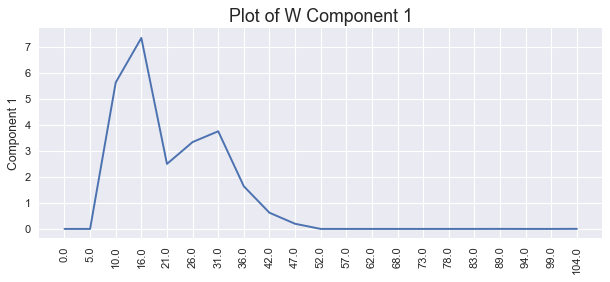

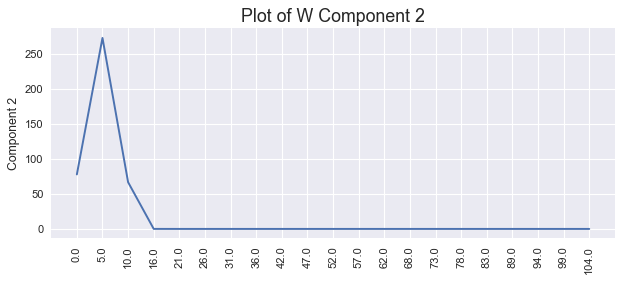

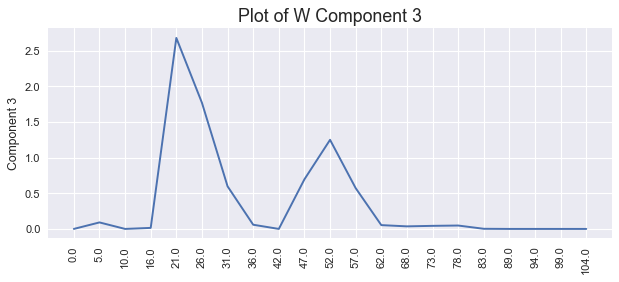

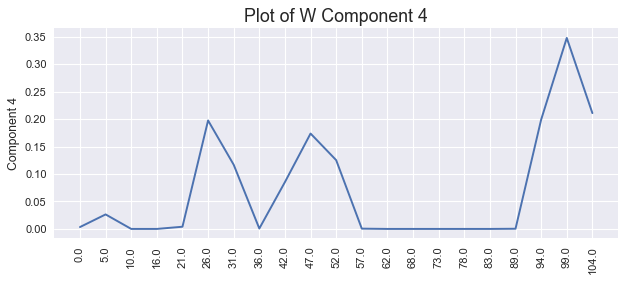

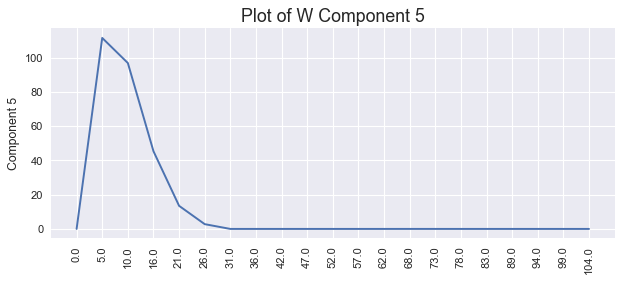

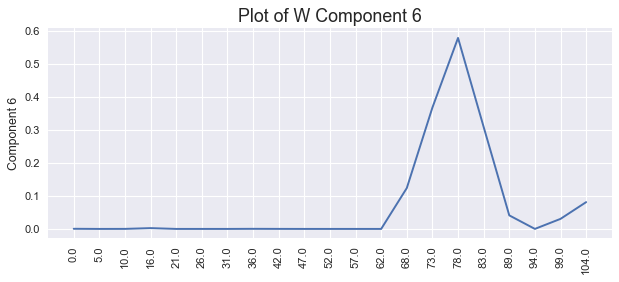

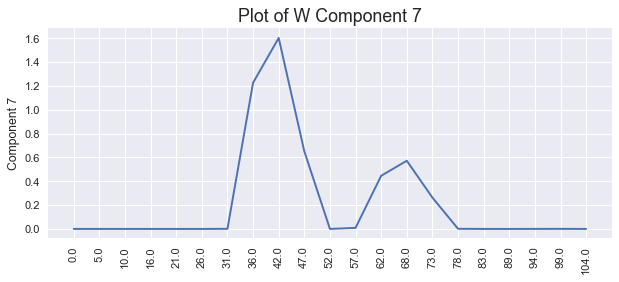

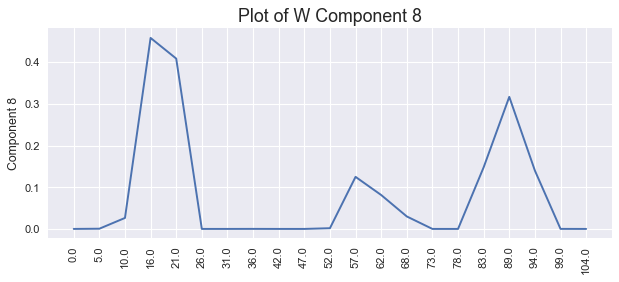

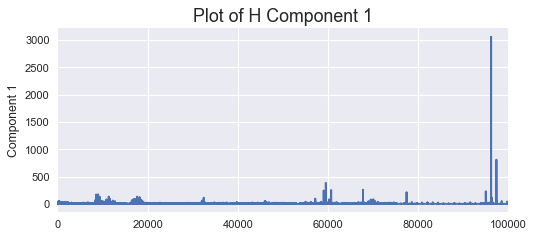

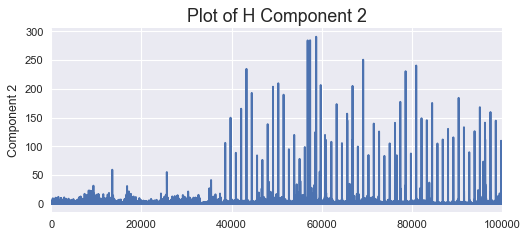

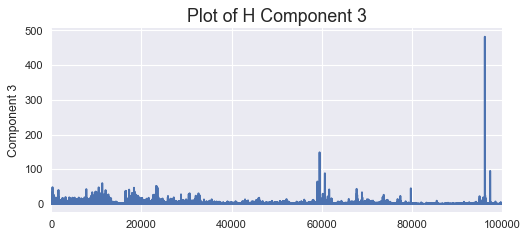

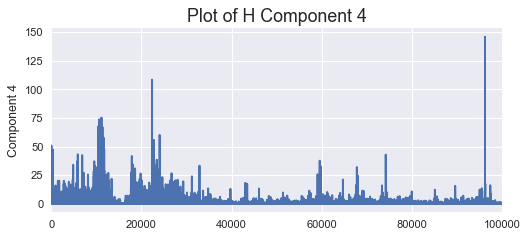

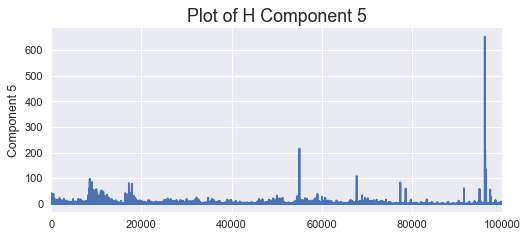

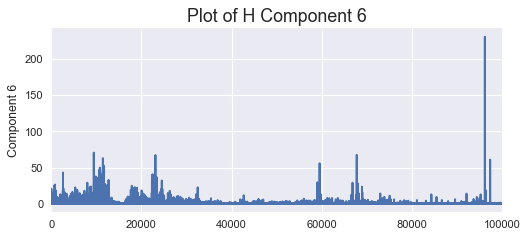

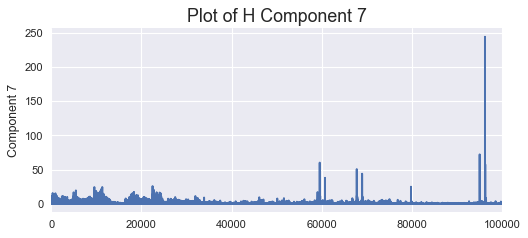

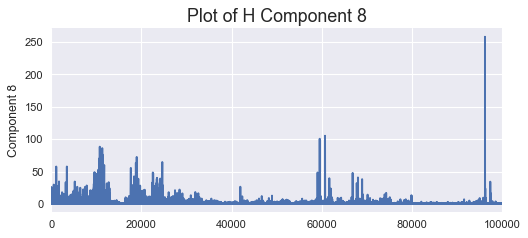

In [9]:
#freq_ticks = np.around(np.linspace(0, 100, num=len(filter_row_idx)), decimals=0)
freq_ticks = f[filter_row_idx]
#freq_ticks
plotW(W = W, log=False, x_ticks_l=freq_ticks)
plotH(H = H, log=False, y_ticks_l=None)

# Get a List of Outlier Trials

In [10]:
#del_chnls_idx = [54, 78, 49, 55, 48, 56, 77, 83, 81, 70, 67, 64, 84, 69, 66, 82, 80, 65, 68, 71] 
#del_trls_idx = [[67], [67], [67], [67], [67], [67], [67], [67], [67], [67], [67], [67], [67], [67], [67], [67], [67], [67], [67], [67]] 

In [11]:
#del_chnls_idx = [8, 9, 19, 46, 48, 48, 49, 50, 51, 57, 80, 81, 81, 81, 82]
#del_trls_idx =  [3, 39, 0, 67, 28, 67, 79, 51, 51, 51, 64, 64, 64, 68, 64]
del_chnls_idx = [8, 9, 19, 46, 48,       49, 50, 51, 57, 80, 81, 82]
del_trls_idx =  [3, 39, 0, 67, [28, 67], 79, 51, 51, 51, 64, [64, 64, 68], 64]

In [12]:
len(del_chnls_idx) - len(del_trls_idx)

0

## Delete channel-trial combinations

In [13]:
all_pat_chn_trials_outlier_rem = []
for i, _ in enumerate(all_pat_chn_trials):
    #print(i)
    try:
        del_idx = del_chnls_idx.index(i)
    except ValueError:
        del_idx = -1
        
    if del_idx != -1:
        all_pat_chn_trials_outlier_rem.append(np.delete(arr=all_pat_chn_trials[i], obj=del_trls_idx[del_idx], axis=0))
    else:
        all_pat_chn_trials_outlier_rem.append(all_pat_chn_trials[i])

In [14]:
print(len(all_pat_chn_trials_outlier_rem))

chk_sample_chnl_idx = 57
print(all_pat_chn_trials_outlier_rem[chk_sample_chnl_idx].shape)
print(all_pat_chn_trials[chk_sample_chnl_idx].shape)

85
(83, 1500)
(84, 1500)


In [15]:
all_num_trials = [all_pat_chn_trials_outlier_rem[idx].shape[0] for idx in range(len(all_pat_chn_trials_outlier_rem))]
min_num_trials = min(all_num_trials)
min_idx = all_num_trials.index(min_num_trials)
all_pat_chn_trials_outlier_rem[min_idx].shape

(82, 1500)

## Rerun NMF

In [16]:
def entire_specgram_nmf_wrapper_cust(all_patient_trials,
                                     samp_trial_pop, 
                                     noverlap,
                                    time_samp_prop,
                                    filter_row_idx,                                
                                    log_Sxx,
                                    fs, window, nperseg,
                                    n_components, 
                                    init, 
                                    random_state, 
                                    beta_loss, 
                                    solver,
                                    max_iter):
    
    all_num_trials = [all_patient_trials[idx].shape[0] for idx in range(len(all_patient_trials))]
    min_num_trials = min(all_num_trials)
    min_idx = all_num_trials.index(min_num_trials)    

    trials_samp_idx = samp_idx_without_replace(np_arr=all_patient_trials[min_idx], samp_prop=samp_trial_pop, 
                                               sample_rows=True)
    print(len(trials_samp_idx))

    # Fit the spectrograms and hstack the spectrograms
    comb_all_channels_specgrams = specgram_wrapper(arr_all_trials=all_patient_trials, 
                                                   trials_samp_idx=trials_samp_idx, 
                                                   tot_num_channels=tot_num_channels,
                                                   fs=fs, window=window, nperseg=nperseg,
                                                   filter_row_idx=filter_row_idx, 
                                                   log_Sxx=log_Sxx)

    # randomly sample across time
    time_samp_idx = samp_idx_without_replace(np_arr=comb_all_channels_specgrams, 
                                             samp_prop=time_samp_prop, 
                                             sample_rows=False)
    
    print("comb_all_channels_specgrams:", comb_all_channels_specgrams.shape, sep = " ")
    print("time_samp_idx length:", len(time_samp_idx), sep = " ")

    comb_specgram_time_sample = time_sample_specgram(comb_specgram=comb_all_channels_specgrams, 
                                                     time_samp_idx=time_samp_idx)
    
    print("comb_specgram_time_sample:", comb_specgram_time_sample.shape, sep=" ")
    
    print("STARTING NMF...")
    print(max_iter)
    
    # perform NMF
    V, W, H = nmf_wrapper(comb_all_channels_specgrams=comb_specgram_time_sample, 
                          n_components=n_components,
                          init=init, 
                          random_state=random_state, 
                          beta_loss=beta_loss, 
                          solver=solver,
                          max_iter=max_iter)
    
    print("NMF COMPLETE!")
    
    return V, W, H

In [17]:
V_outlier_rem, W_outlier_rem, H_outlier_rem = entire_specgram_nmf_wrapper_cust(all_patient_trials=all_pat_chn_trials_outlier_rem,
                                                                               samp_trial_pop=samp_trial_pop, 
                                                                               noverlap=noverlap,
                                                                               time_samp_prop=time_samp_prop,
                                                                               filter_row_idx=filter_row_idx,                                
                                                                               log_Sxx=log_Sxx,
                                                                               fs=fs, 
                                                                               window=window, 
                                                                               nperseg=nperseg,
                                                                               n_components=n_components, 
                                                                               init=init, 
                                                                               random_state=random_state, 
                                                                               beta_loss=beta_loss, 
                                                                               solver=solver,
                                                                               max_iter=max_iter)

82
comb_all_channels_specgrams: (21, 97580)
time_samp_idx length: 97580
comb_specgram_time_sample: (21, 97580)
STARTING NMF...
400
V: (21, 97580)
W: (21, 8)
H: (8, 97580)
NMF COMPLETE!


97580


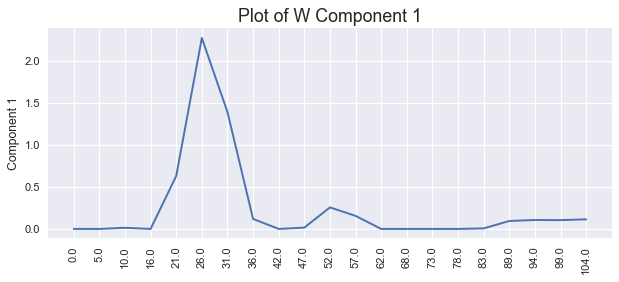

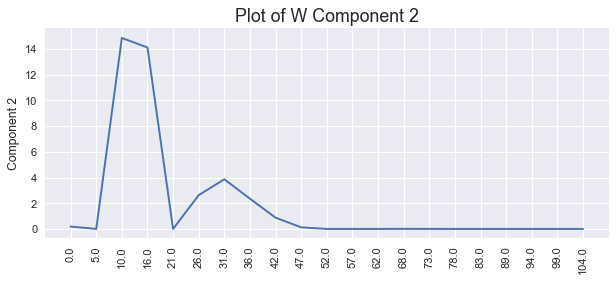

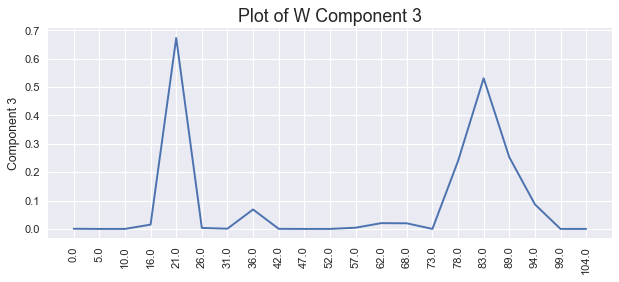

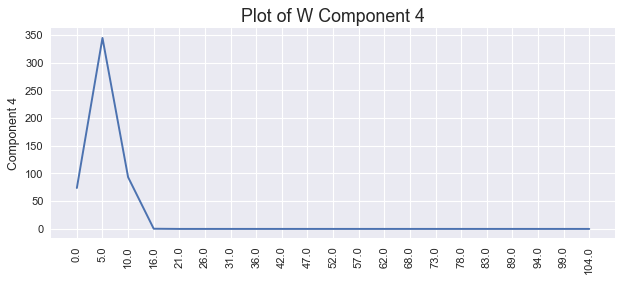

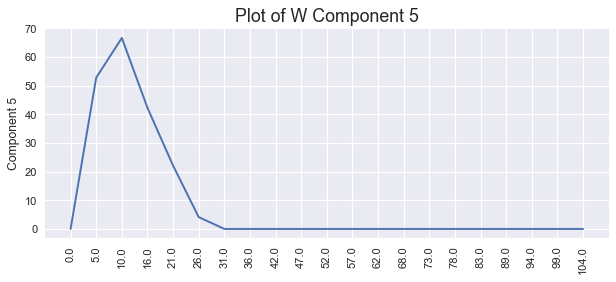

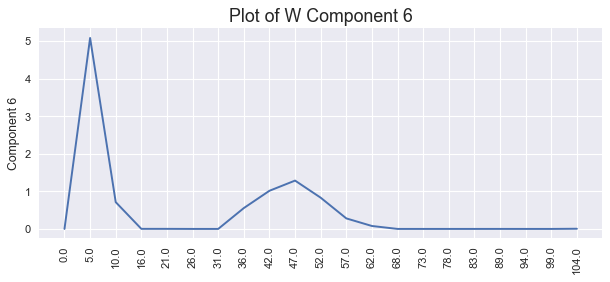

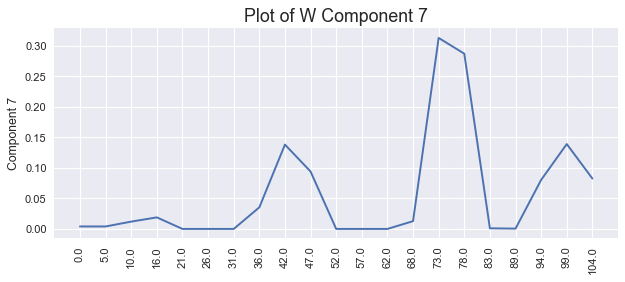

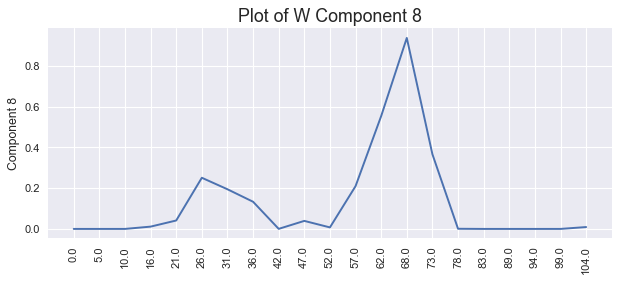

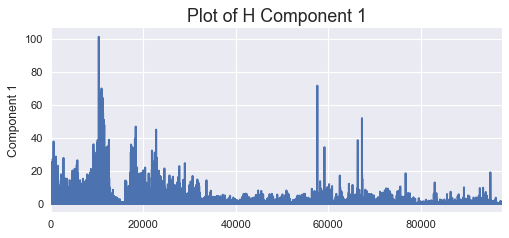

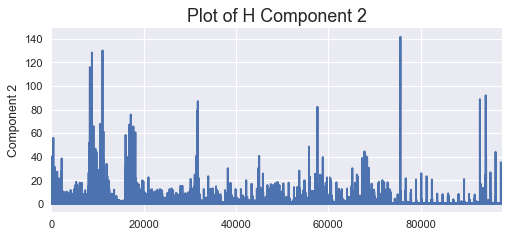

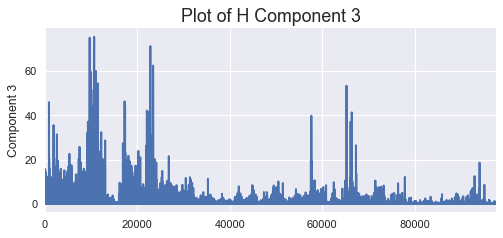

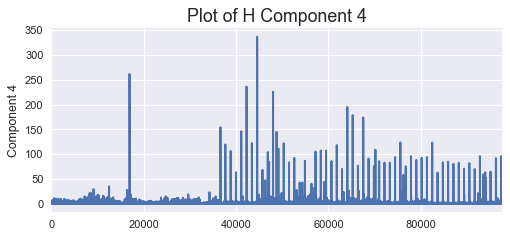

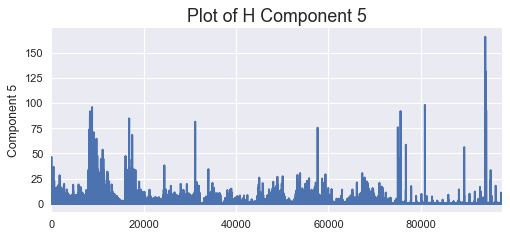

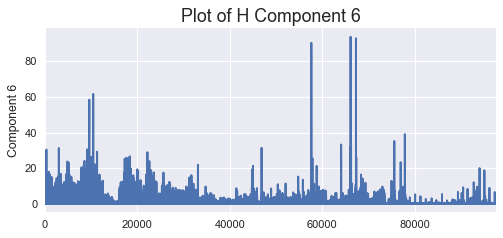

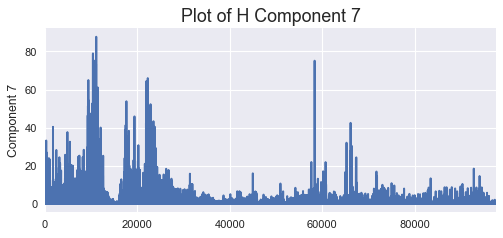

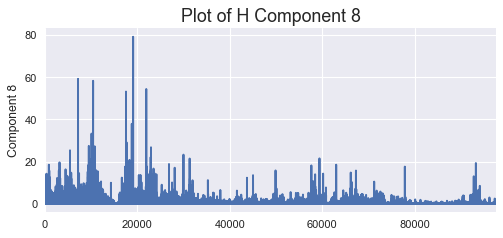

In [18]:
plotW(W = W_outlier_rem, log=False, x_ticks_l=freq_ticks)
plotH(H = H_outlier_rem, log=False, y_ticks_l=None)

## Re-run NMF except use L2 normalization of trials - outliers removed

In [19]:
base_data_dir = "/Users/shamindras/PERSONAL/LEARNING/REPOS/neuroada_analysis/data/localizer_erp"
patient_num = 41
tot_num_channels = range(85)
trials_type = "category"
session_idx = 1
core_cat = "Faces"
ord = 2 # L2 norm

# Spectrogram parameters
fs = 1e3
window = 'hann'
nperseg = 192
noverlap = 96
log_Sxx=False
spec_trial_num = 10 # Specific Trial Index that we are going to test
spec_trial_idx = spec_trial_num - 1

channel_num = 10
channel_idx = channel_num - 1

samp_trial_pop = 1.0 # 100% sampling of trials
time_samp_prop = 1.0 # 100% sampling of time
filter_row_idx=range(21)
n_components = 8 
init = 'random' 
random_state = 0
beta_loss = 'itakura-saito' # IS Divergence
solver = 'mu'
max_iter = 400

## First create L2 normalized (outliers removed trials)

In [20]:
print(ord)
all_pat_chn_trials_L2 = get_all_pat_chn_trials(base_data_dir=base_data_dir, patient_num=patient_num, 
                                   session_idx=session_idx, tot_num_channels=tot_num_channels, 
                                   core_cat=core_cat, trials_type=trials_type, ord=ord)
len(all_pat_chn_trials_L2)

2
we are using the 2-norm to normalize trials


85

In [21]:
all_pat_chn_trials_outlier_rem_L2 = []
for i, _ in enumerate(all_pat_chn_trials_L2):
    #print(i)
    try:
        del_idx = del_chnls_idx.index(i)
    except ValueError:
        del_idx = -1
        
    if del_idx != -1:
        all_pat_chn_trials_outlier_rem_L2.append(np.delete(arr=all_pat_chn_trials_L2[i], obj=del_trls_idx[del_idx], axis=0))
    else:
        all_pat_chn_trials_outlier_rem_L2.append(all_pat_chn_trials_L2[i])

In [22]:
print(len(del_trls_idx) - len(del_chnls_idx))
len(all_pat_chn_trials_outlier_rem_L2)

0


85

In [23]:
V_outlier_rem_L2, W_outlier_rem_L2, H_outlier_rem_L2 = entire_specgram_nmf_wrapper_cust(all_patient_trials=all_pat_chn_trials_outlier_rem_L2,
                                                                               samp_trial_pop=samp_trial_pop, 
                                                                               noverlap=noverlap,
                                                                               time_samp_prop=time_samp_prop,
                                                                               filter_row_idx=filter_row_idx,                                
                                                                               log_Sxx=log_Sxx,
                                                                               fs=fs, 
                                                                               window=window, 
                                                                               nperseg=nperseg,
                                                                               n_components=n_components, 
                                                                               init=init, 
                                                                               random_state=random_state, 
                                                                               beta_loss=beta_loss, 
                                                                               solver=solver,
                                                                               max_iter=max_iter)

82
comb_all_channels_specgrams: (21, 97580)
time_samp_idx length: 97580
comb_specgram_time_sample: (21, 97580)
STARTING NMF...
400
V: (21, 97580)
W: (21, 8)
H: (8, 97580)
NMF COMPLETE!


97580


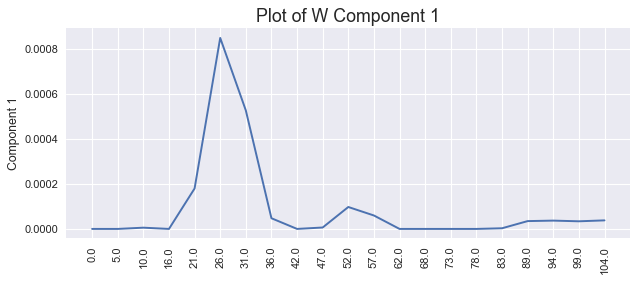

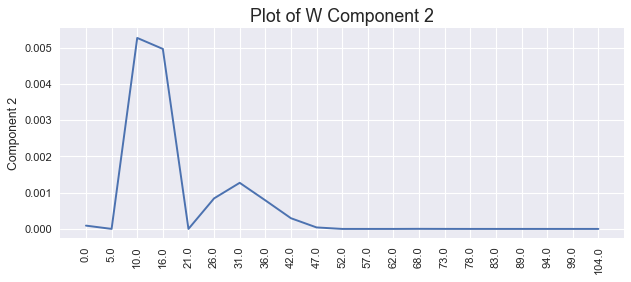

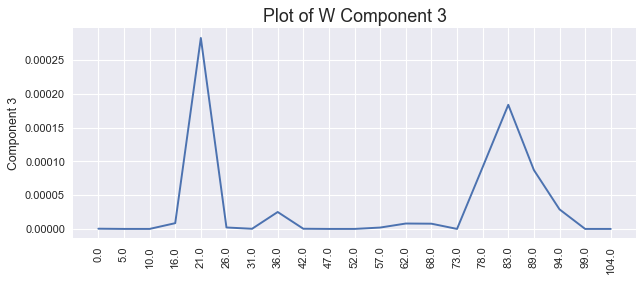

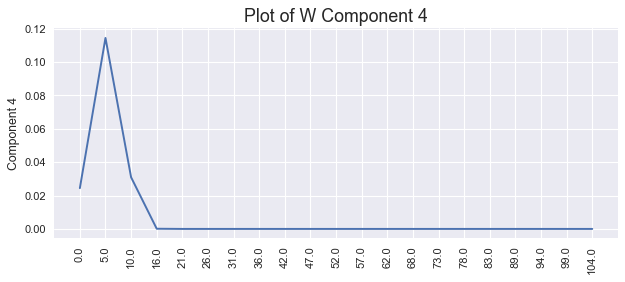

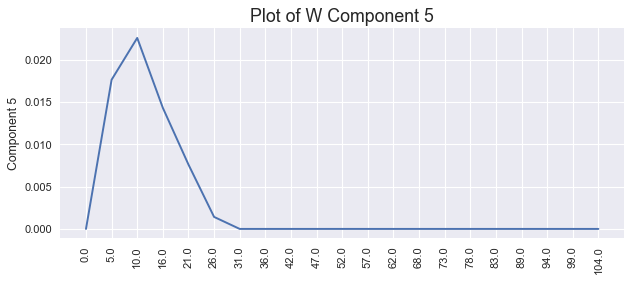

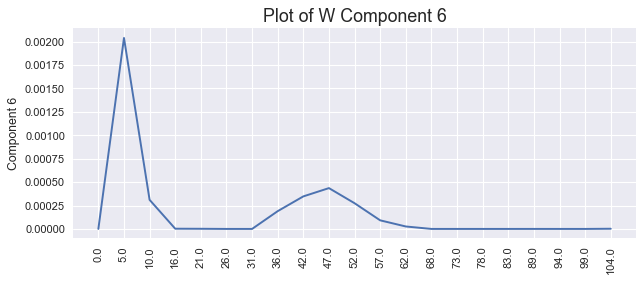

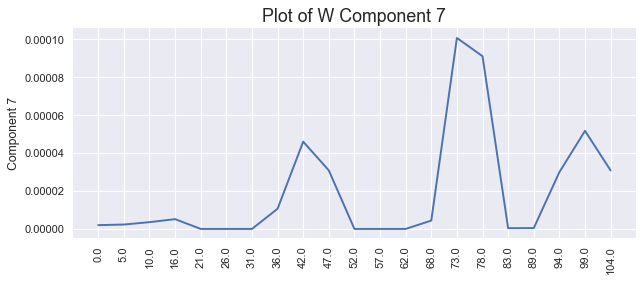

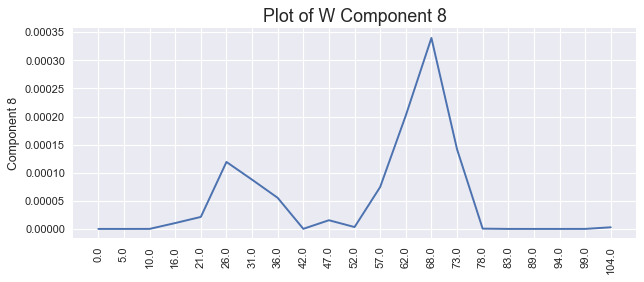

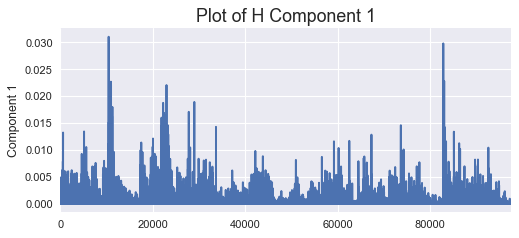

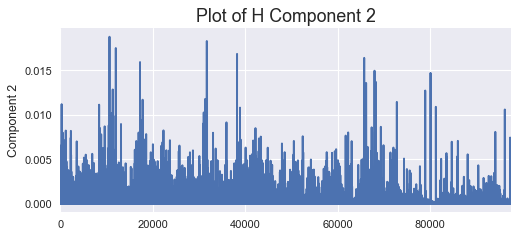

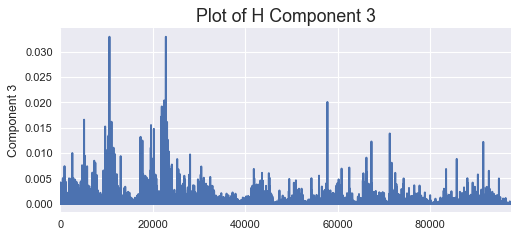

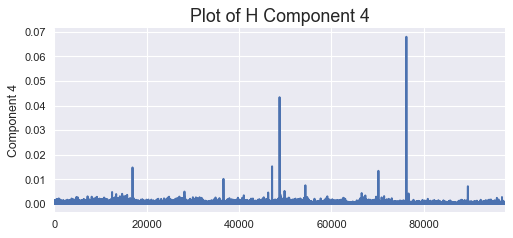

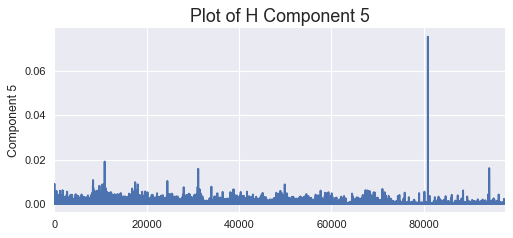

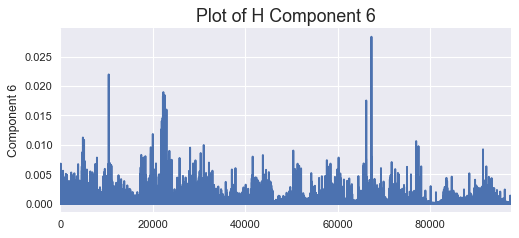

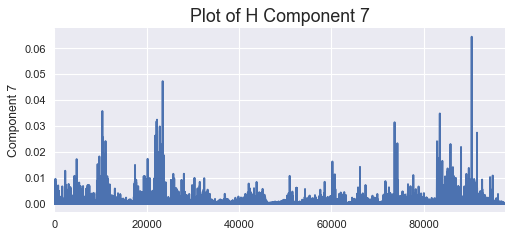

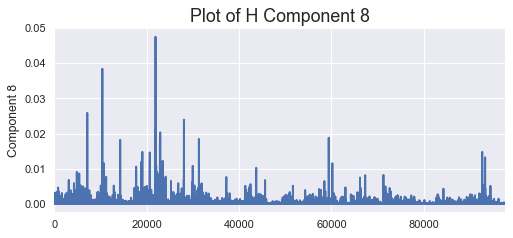

In [24]:
plotW(W = W_outlier_rem_L2, log=False, x_ticks_l=freq_ticks)
plotH(H = H_outlier_rem_L2, log=False, y_ticks_l=None)

## Rescale NMF using zscore approach

In [25]:
def zscore_manl(arr, col_min_rng, col_max_rng):
    trunc_arr = arr[col_min_rng:col_max_rng]
    mu = np.mean(trunc_arr)
    sd = np.std(trunc_arr, ddof=1)
    return (arr - mu)/sd

def only_specgram_trials(arr_all_trials, fs, window, nperseg, noverlap,
                    trials_samp_idx=None, filter_row_idx=None, log_Sxx=False):
    """Produce a combined list of spectrograms concatenated by frequency (horizontally)"""
    if trials_samp_idx is None:
        # Produce spectrograms for all of the trials
        all_trial_idx = range(arr_all_trials.shape[0])
        trial_specgrams = [erp_gen_spectrogram(x = arr_all_trials[idx], fs = fs, window = window, nperseg = nperseg,
                                               noverlap=noverlap, log_Sxx=log_Sxx)[2] for idx in all_trial_idx]
    else:
        # Produce spectrograms for only the specified trials (by trial indices)
        trial_specgrams = [erp_gen_spectrogram(x = arr_all_trials[idx], fs = fs, window = window, nperseg = nperseg, 
                                               noverlap=noverlap, log_Sxx=log_Sxx)[2] for idx in trials_samp_idx]
    
    # Filter the rows of the combined spectrogram    
    if filter_row_idx is None:
        # Don't filter any rows in the combined spectrogram
        trial_specgrams = trial_specgrams
    else:
        trial_specgrams = [specgram[filter_row_idx] for specgram in trial_specgrams]
    return trial_specgrams


def zscore_specgram(Sxx, col_min_rng, col_max_rng):
    out = [zscore_manl(arr=Sxx[row_idx, :], col_min_rng=col_min_rng, col_max_rng=col_max_rng) 
           for row_idx in range(Sxx.shape[0])]
    return np.vstack(out)

def zscore_specgram_chnl(arr_all_trials, col_min_rng, col_max_rng, 
                            fs, window, nperseg, noverlap,
                            trials_samp_idx, filter_row_idx, log_Sxx):
    """"""
    # Get spectrograms for all of the trials
    specgram_trials = only_specgram_trials(arr_all_trials=arr_all_trials, fs=fs, window=window, nperseg=nperseg, noverlap=noverlap,
                                           trials_samp_idx=trials_samp_idx, filter_row_idx=filter_row_idx, log_Sxx=log_Sxx)

    # Z-score sprectrograms
    z_specgrams = [zscore_specgram(Sxx, col_min_rng=col_min_rng, col_max_rng=col_max_rng)
                   for Sxx in specgram_trials]
    #print(f"the dimension of z_specgrams[0] is {z_specgrams[0].shape}")
    
    comb_z_specgrams = np.hstack(z_specgrams)
    #print(f"the dimension of comb_z_specgrams is {comb_z_specgrams.shape}")
        
    return comb_z_specgrams

In [26]:
# For z_score
# TODO: this depends on the frequency! Make this automated
col_min_rng=1 
col_max_rng=5

In [27]:
zs = [zscore_specgram_chnl(arr_all_trials=all_pat_chn_trials_outlier_rem[chn_idx], 
                           col_min_rng=col_min_rng, col_max_rng=col_max_rng, 
                           fs=fs, window=window, nperseg=nperseg, noverlap=noverlap,
                           trials_samp_idx=None, filter_row_idx=filter_row_idx, log_Sxx=False) for chn_idx in range(len(all_pat_chn_trials_outlier_rem))]

zs_all = np.hstack(zs)

In [28]:
def entire_specgram_nmf_wrapper_cust_zscore(all_patient_trials,
                                            samp_trial_pop, 
                                            noverlap,
                                            time_samp_prop,
                                            filter_row_idx,                                
                                            log_Sxx,
                                            fs, window, nperseg,
                                            n_components, 
                                            init, 
                                            random_state, 
                                            beta_loss, 
                                            solver,
                                            max_iter,
                                            col_min_rng,
                                            col_max_rng):
    
    all_num_trials = [all_pat_chn_trials_outlier_rem[idx].shape[0] for idx in range(len(all_pat_chn_trials_outlier_rem))]
    min_num_trials = min(all_num_trials)
    min_idx = all_num_trials.index(min_num_trials)    

    trials_samp_idx = samp_idx_without_replace(np_arr=all_pat_chn_trials_outlier_rem[min_idx], samp_prop=samp_trial_pop, 
                                               sample_rows=True)
    print(len(trials_samp_idx))

    # Fit the spectrograms and hstack the spectrograms - NOTE these are zscored!
    zs = [zscore_specgram_chnl(arr_all_trials=all_pat_chn_trials_outlier_rem[chn_idx], 
                           col_min_rng=col_min_rng, col_max_rng=col_max_rng, 
                           fs=fs, window=window, nperseg=nperseg, noverlap=noverlap,
                           trials_samp_idx=trials_samp_idx, filter_row_idx=filter_row_idx, log_Sxx=log_Sxx) for chn_idx in range(len(all_pat_chn_trials_outlier_rem))]

    comb_all_channels_specgrams = np.hstack(zs)

    # randomly sample across time
    time_samp_idx = samp_idx_without_replace(np_arr=comb_all_channels_specgrams, 
                                             samp_prop=time_samp_prop, 
                                             sample_rows=False)
    
    print("comb_all_channels_specgrams:", comb_all_channels_specgrams.shape, sep = " ")
    print("time_samp_idx length:", len(time_samp_idx), sep = " ")

    comb_specgram_time_sample = time_sample_specgram(comb_specgram=comb_all_channels_specgrams, 
                                                     time_samp_idx=time_samp_idx)
    
    print("comb_specgram_time_sample:", comb_specgram_time_sample.shape, sep=" ")
    
    print("STARTING NMF...")
    print(max_iter)
    
    # perform NMF
    V, W, H = nmf_wrapper(comb_all_channels_specgrams=comb_specgram_time_sample, 
                          n_components=n_components,
                          init=init, 
                          random_state=random_state, 
                          beta_loss=beta_loss, 
                          solver=solver,
                          max_iter=max_iter)
    
    print("NMF COMPLETE!")
    
    return V, W, H

In [29]:
col_min_rng = 1
col_max_rng = 5

V_outlier_rem_zs, W_outlier_rem_zs, H_outlier_rem_zs = entire_specgram_nmf_wrapper_cust_zscore(all_patient_trials=all_pat_chn_trials_outlier_rem,
                                                                                               samp_trial_pop=samp_trial_pop, 
                                                                                               noverlap=noverlap,
                                                                                               time_samp_prop=time_samp_prop,
                                                                                               filter_row_idx=filter_row_idx,                                
                                                                                               log_Sxx=log_Sxx,
                                                                                               fs=fs, 
                                                                                               window=window, 
                                                                                               nperseg=nperseg,
                                                                                               n_components=n_components, 
                                                                                               init=init, 
                                                                                               random_state=random_state, 
                                                                                               beta_loss=beta_loss, 
                                                                                               solver=solver,
                                                                                               max_iter=max_iter,
                                                                                               col_min_rng=col_min_rng,
                                                                                               col_max_rng=col_max_rng)

82
comb_all_channels_specgrams: (21, 97580)
time_samp_idx length: 97580
comb_specgram_time_sample: (21, 97580)
STARTING NMF...
400


ValueError: Negative values in data passed to NMF (input X)